In [2777]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline, interp1d
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path
from matplotlib.lines import Line2D
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from uncertainties import ufloat, unumpy
from scipy.odr import ODR, Model, Data, RealData
from scipy.optimize import curve_fit
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker
from scipy.integrate import quad
import sympy as sp
from sympy import symbols, Eq, solve
from scipy import constants

## 2.1 Überprüfung des Malusschen Gesetzes

In [2778]:
file_path = '/Users/danielmiksch/Downloads/C40_1_neu.csv'
data_C40_1 = pd.read_csv(file_path, sep=',')

In [2779]:
np.set_printoptions(suppress=True, precision=10)
data_np_21 = data_C40_1.to_numpy()

theta_21 = data_np_21[:,0]
U_21 = data_np_21[:,1]
theta_21_rad = np.radians(theta_21)

deg = np.radians(np.arange(190, 360, 10))
data_sym = U_21[::-1][1:-1]
extra_data = np.column_stack((deg, data_sym))
extra_data

array([[ 3.3161255788, 17.8         ],
       [ 3.490658504 , 16.2         ],
       [ 3.6651914292, 13.4         ],
       [ 3.8397243544, 10.5         ],
       [ 4.0142572796,  7.          ],
       [ 4.1887902048,  4.4         ],
       [ 4.36332313  ,  2.          ],
       [ 4.5378560552,  0.7         ],
       [ 4.7123889804,  0.3         ],
       [ 4.8869219056,  1.3         ],
       [ 5.0614548308,  3.3         ],
       [ 5.235987756 ,  5.7         ],
       [ 5.4105206812,  8.9         ],
       [ 5.5850536064, 12.2         ],
       [ 5.7595865316, 15.          ],
       [ 5.9341194568, 17.2         ],
       [ 6.108652382 , 18.4         ]])

In [2780]:
d_theta = np.radians(2.5)
d_theta_21 = np.full(len(theta_21), d_theta)
d_deg = np.full(len(deg), d_theta)
d_U_21 = (U_21 * 0.011 + 2)
d_data_sym = (data_sym * 0.011 + 2)

In [2781]:
theta_model = np.linspace(0, 2*np.pi, 1000)
I_model = U_21[0] * (np.cos(theta_model)) ** 2

/var/folders/_s/ymfv76ms5rs0hd9l43mh92_80000gn/T/ipykernel_30803/3172687617.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


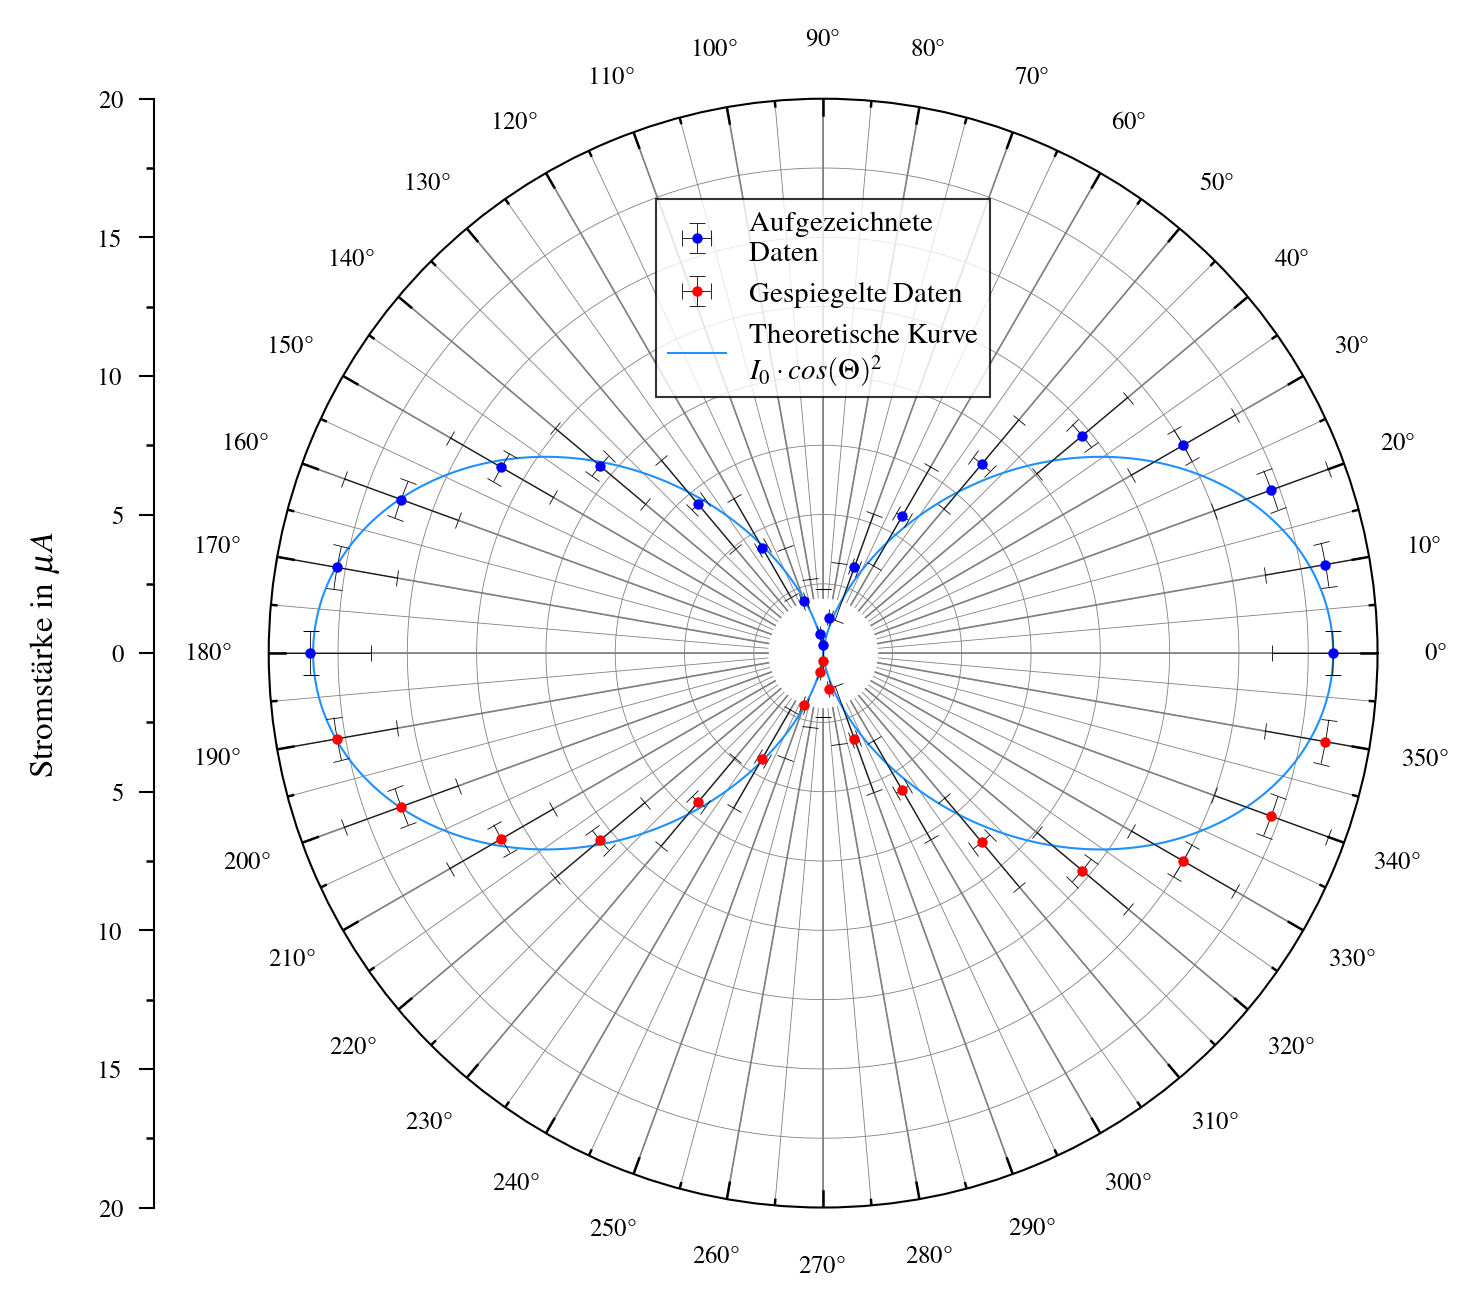

In [2782]:
plt1 = fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': 'polar'})

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

ax.plot(theta_model, I_model, linewidth=0.5, c='dodgerblue', label='Theoretische Kurve\n $I_0\cdot cos(\Theta)^2$')

#facecolor for circles 'o'
ax.errorbar(deg, data_sym, xerr=d_deg, yerr=d_data_sym, capsize=2, ecolor='black', elinewidth=0.2, capthick=0.2, markersize=5, fmt=".", markeredgecolor='none', c="red", zorder=2, label='Gespiegelte Daten')
ax.errorbar(theta_21_rad, U_21, xerr=d_theta_21, yerr=d_U_21, capsize=2, ecolor='black', elinewidth=0.2, capthick=0.2, markersize=5, fmt=".", markeredgecolor='none', c="blue", zorder=2, label='Aufgezeichnete\n Daten')

ax.set_rlim(0, 20)
labels = ['' for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.set_rlabel_position(3)

#Setting ticks for theta
ax.set_xticks(np.linspace(0, 2*np.pi, 36, endpoint=False))
long_tick = [ax.get_rmax(), ax.get_rmax()*0.97]
short_tick = [ax.get_rmax(), ax.get_rmax()*0.99]  
for i, t in enumerate(np.deg2rad(np.arange(0, 360, 5))):
    if i % 2 == 0:  # Prüft, ob der Index gerade ist
        ax.plot([t, t], long_tick, lw=0.6, color="k")
    else:
        ax.plot([t, t], short_tick, lw=0.6, color="k")



ax.grid(False)

#Minor grid lines angle
r_max = ax.get_rmax()
for angle in np.deg2rad(np.arange(0, 360, 5)):
    ax.plot([angle, angle], [2, r_max], color='gray', linewidth=0.2, zorder=1)  # Setze die gewünschte Linienfarbe und -stärke
    
#Major grid lines angle
for angle in np.deg2rad(np.arange(0, 360, 10)):
    ax.plot([angle, angle], [2, r_max], color='gray', linewidth=0.4, zorder=1)

#Minor grid lines radius
for r in np.arange(0, 20, 2.5):
    theta = np.linspace(0, 2*np.pi, 1000)
    ax.plot(theta, [r] * len(theta), linewidth=0.2, color='gray', zorder=1)

# Size Angle Labels
for label in ax.get_xticklabels():
    label.set_fontsize(6)
    
ax.set_ylabel('Stromstärke in $\mu A$', labelpad=50, fontsize=8)


X_OFFSET = 0.06# to control how far the scale is from the plot (axes coordinates)
def add_scale(ax):
    # add extra axes for the scale
    rect = ax.get_position()
    rect = (rect.xmin-X_OFFSET, rect.ymin, # x, y
            rect.width, rect.height) # width, height
    scale_ax = ax.figure.add_axes(rect)
    # hide most elements of the new axes
    for loc in ['right', 'top', 'bottom']:
        scale_ax.spines[loc].set_visible(False)
    scale_ax.tick_params(bottom=False, labelbottom=False)
    scale_ax.patch.set_visible(False) # hide white background
    # adjust the scale    
    scale_ax.set_ylim(-20, 20)

    ticks = [-20, -15, -10, -5, 0, 5, 10, 15, 20]
    ticklabels = [str(abs(t)) for t in ticks]

    scale_ax.set_yticks(ticks)
    scale_ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
    scale_ax.set_yticklabels(ticklabels ,fontsize=6)
    scale_ax.tick_params(axis='y', width=0.5)
    
    for spine in scale_ax.spines.values():
        spine.set_linewidth(0.5)

add_scale(ax)

#Circle in the middle
# center_circle = plt.Circle((0, 0), 80, transform=ax.transData._b, color='white', zorder=3)
# ax.add_patch(center_circle)

# Width outer circle
ax.spines['polar'].set_linewidth(0.5)

handles_ax, labels_ax = ax.get_legend_handles_labels()

handles = handles_ax 
labels = labels_ax

order = [2, 1, 0]  # Beachten Sie, dass dies an Ihre spezifische Situation angepasst werden muss

legend = ax.legend([handles[idx] for idx in order],
          [labels[idx] for idx in order],
          loc="upper left",
          bbox_to_anchor=(0.336, 0.923),
          fancybox=False,
          edgecolor='black',
          fontsize=7)
legend.get_frame().set_linewidth(.5)

plt.show()

# fig.savefig("/Users/danielmiksch/Downloads/C40_winkel.pdf")

## Zuckerlösung

In [2783]:
file_path = '/Users/danielmiksch/Downloads/C40_zucker.csv'
file_path1 = '/Users/danielmiksch/Downloads/C40_zucker_1.csv'
data_zucker = pd.read_csv(file_path, sep=',')
data_zucker1 = pd.read_csv(file_path1, sep=',')

np.set_printoptions(suppress=True, precision=10)
zucker = data_zucker.to_numpy()
zucker1 = data_zucker1.to_numpy()

In [2784]:
diff = abs(zucker[:,0] - zucker[:,1])
std = np.std(diff, ddof=1)
mean = np.mean(diff)
s_mean = std / np.sqrt(len(diff))
ufloat(mean, s_mean)

8.380000000000019+/-0.5505905920009925

### Lösung mit 100mg/ml

In [2785]:
V = ufloat(2 / 10000, 1e-5)
m = ufloat(0.0201, 0.0001)

c = m / V #kg/m3
l = ufloat(0.25, 0.01) #m
c

100.5+/-5.0498143530232875

In [2786]:
diff = abs(unumpy.uarray(zucker1[:,0], np.full(len(zucker1), 0.2)) - unumpy.uarray(zucker1[:,1], np.full(len(zucker1), 0.2)))

std = np.std(unumpy.nominal_values(diff), ddof=1)
mean = np.mean(unumpy.nominal_values(diff))
s_mean = std / np.sqrt(len(diff))

theta = ufloat(mean, s_mean)
theta1 = sum(diff) / len(diff)

print(theta)
# print(theta1)
 
theta_spec = theta1 / (l * c)
print(theta_spec)


theta_new = theta_spec * 10

print("theta = ({} +/- {})".format(unumpy.nominal_values(theta_new), unumpy.std_devs(theta_new)))

17.70+/-0.15
0.70+/-0.05
theta = (7.0447761194029805 +/- 0.4570898097874298)


### Lösung unbekannter Konzentration

In [2787]:
diff = abs(unumpy.uarray(zucker1[:,2], np.full(len(zucker1), 0.2)) - unumpy.uarray(zucker1[:,3], np.full(len(zucker1), 0.2)))

std = np.std(unumpy.nominal_values(diff), ddof=1)
mean = np.mean(unumpy.nominal_values(diff))
s_mean = std / np.sqrt(len(diff))

theta = ufloat(mean, s_mean)
theta1 = sum(diff) / len(diff)

c_new = theta1 / (theta_spec * l)
print("cnew = ({} +/- {})".format(unumpy.nominal_values(c_new), unumpy.std_devs(c_new)))


cnew = (63.40395480225993 +/- 3.369206520432244)


## Faraday

### B-Feld

In [2788]:
file_path = '/Users/danielmiksch/Downloads/C40_B1.csv'
data_C40_B1 = pd.read_csv(file_path, sep=',')

In [2789]:
np.set_printoptions(suppress=True, precision=10)
data_np_B1 = data_C40_B1.to_numpy()

In [2790]:
data_np_B1[:,0] = abs(data_np_B1[:,0] - data_np_B1[0, 0])
x = data_np_B1[:,0]
B = data_np_B1[:,1]
B_max = data_np_B1[:,1] + 0.1

In [2791]:
f_B = interp1d(x, B, kind='cubic')
f_B_max = interp1d(x, B_max, kind='cubic')
x_plot = np.linspace(0, np.max(x), 1000)

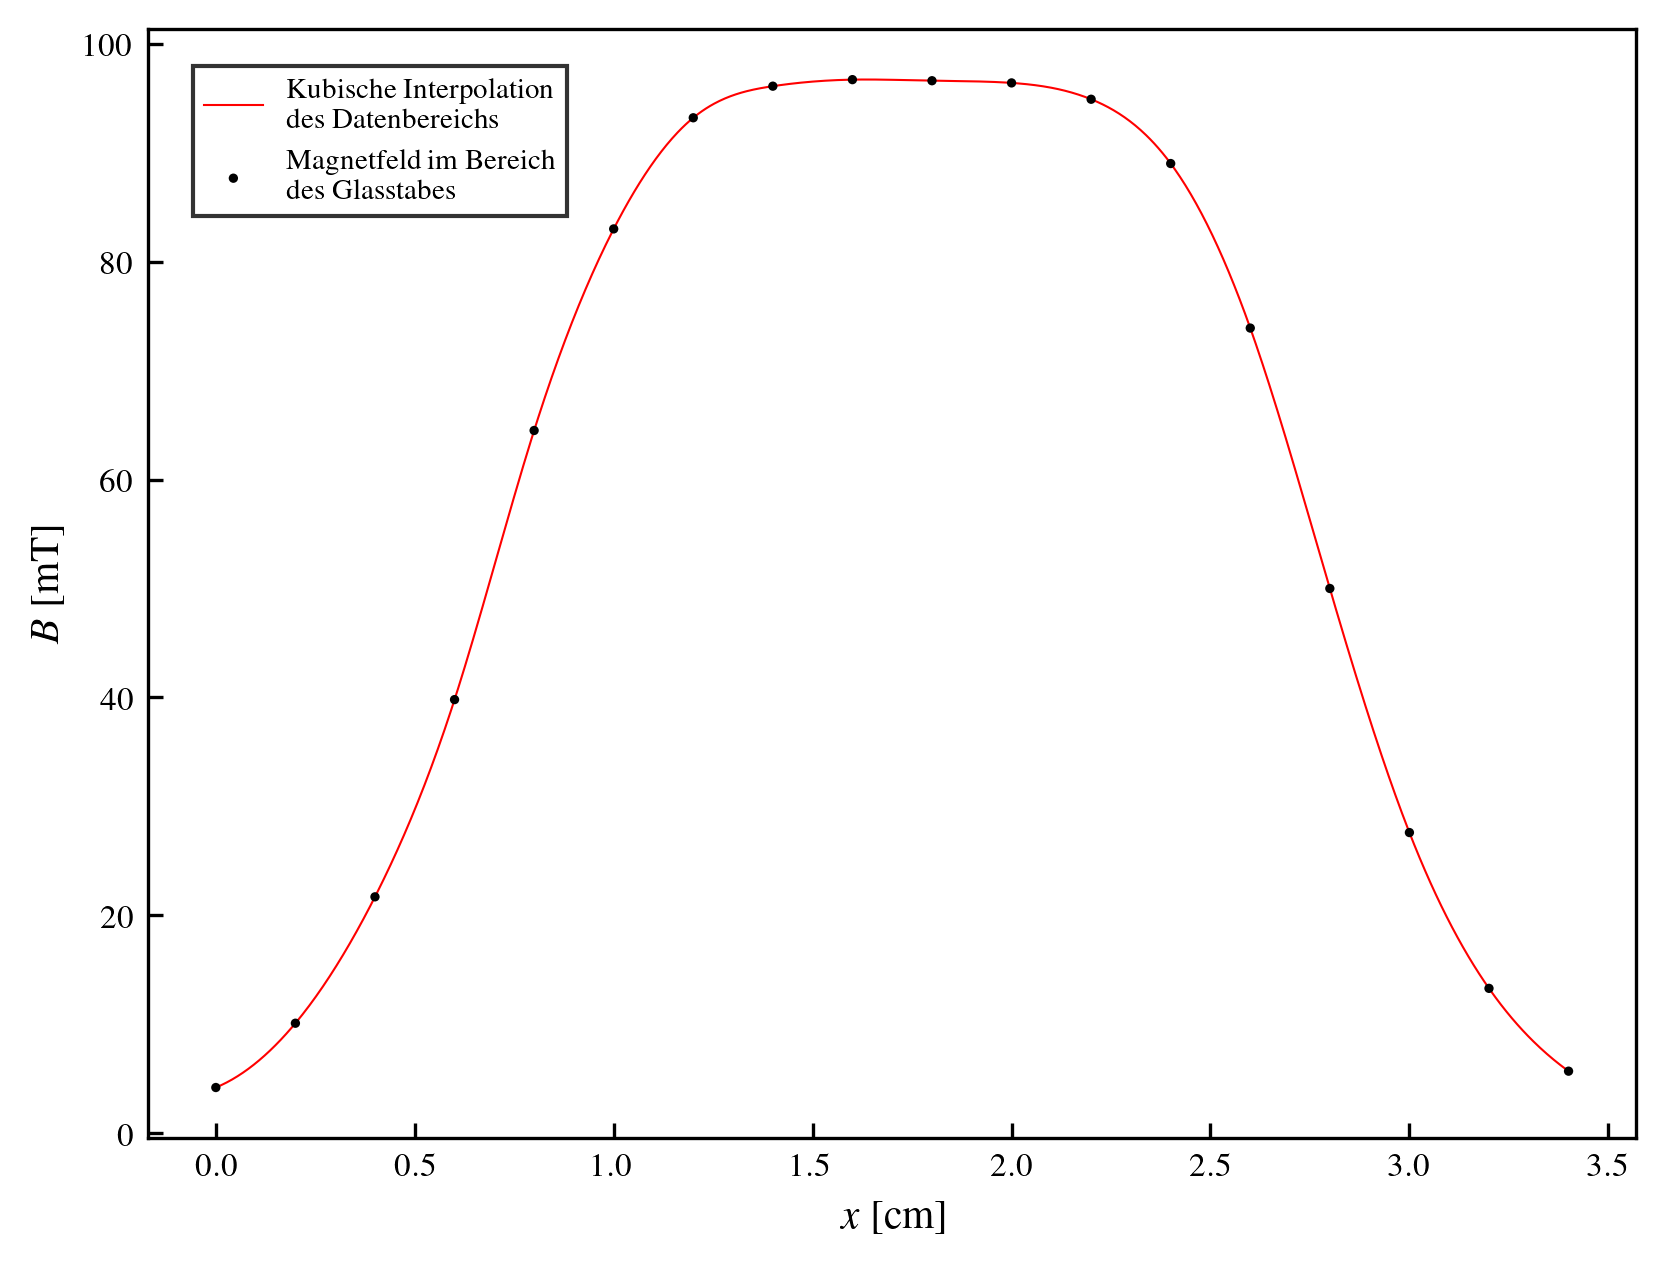

In [2792]:
fig, ax = plt.subplots(dpi=300)

plt.plot(x_plot, f_B(x_plot), color='red', linewidth=0.5, zorder=2, label='Kubische Interpolation\n des Datenbereichs')
plt.scatter(x, B, marker='.', s=20, edgecolors='none', color='black', label='Magnetfeld im Bereich\n des Glasstabes', zorder=2)


ax.set_ylabel('$B$ [mT]')
ax.set_xlabel('$x$ [cm]')

plt.tick_params(direction='in', labelsize=8)

plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98), fancybox=False, edgecolor='black', fontsize=7)

# fig.savefig("/Users/danielmiksch/Downloads/plot_flaeche.png")

In [2793]:
area, _ = quad(f_B, 0, 3.045)
area_max, _ = quad(f_B_max, 0, 3.045)
d_area = area_max - area

area = ufloat(area, d_area)

B_eff = area / ufloat(3.045, 0.001)
B_eff

67.61005240186864+/-0.10243535117987976

In [2794]:
alpha = B_eff / ufloat(np.max(B), 0.1)

In [2795]:
I_all = unumpy.uarray([1.5, 1.8, 2.1, 2.4, 2.7, 3.0], [0 for i in range(6)])
B_all = unumpy.uarray([90.6, 116.2, 135.6, 153.9, 171.4, 188.6], [0.1 for i in range(6)])
B_eff_all = alpha * B_all

#get separate values
B_eff_all = unumpy.nominal_values(B_eff_all) / 1000
d_B = unumpy.std_devs(B_eff_all)

In [2796]:
theta0 = 1
d_theta = 0.5
lamb_505 = unumpy.uarray([5, 5.5, 7, 7, 7.5, 8], [d_theta for i in range(6)]) - theta0

l_505 = np.radians(unumpy.nominal_values(lamb_505))
d_505 = np.radians(unumpy.std_devs(lamb_505))

In [2797]:
theta0 = -0.5
lamb_440 = unumpy.uarray([4, 4.5, 5, 6, 6.5, 7], [d_theta for i in range(6)]) - theta0

l_440 = np.radians(unumpy.nominal_values(lamb_440))
d_440 = np.radians(unumpy.std_devs(lamb_440))

In [2798]:
theta0 = 1.5
lamb_525 = unumpy.uarray([4.5, 6, 6.5, 6, 7, 8], [d_theta for i in range(6)]) - theta0

l_525 = np.radians(unumpy.nominal_values(lamb_525))
d_525 = np.radians(unumpy.std_devs(lamb_525))

In [2799]:
theta0 = 1
lamb_580 = unumpy.uarray([4, 4, 4.5, 5, 5.5, 5.5], [d_theta for i in range(6)]) - theta0

l_580 = np.radians(unumpy.nominal_values(lamb_580))
d_580 = np.radians(unumpy.std_devs(lamb_580))

In [2800]:
def f_lin(x, b, a):
    return b * x + a

In [2801]:
popt440, pcov440 = curve_fit(f_lin, B_eff_all, l_440, sigma=d_440, absolute_sigma=True)
popt505, pcov505 = curve_fit(f_lin, B_eff_all, l_505, sigma=d_505, absolute_sigma=True)
popt525, pcov525 = curve_fit(f_lin, B_eff_all, l_525, sigma=d_525, absolute_sigma=True)
popt580, pcov580 = curve_fit(f_lin, B_eff_all, l_580, sigma=d_580, absolute_sigma=True)

### Plot Theta and B

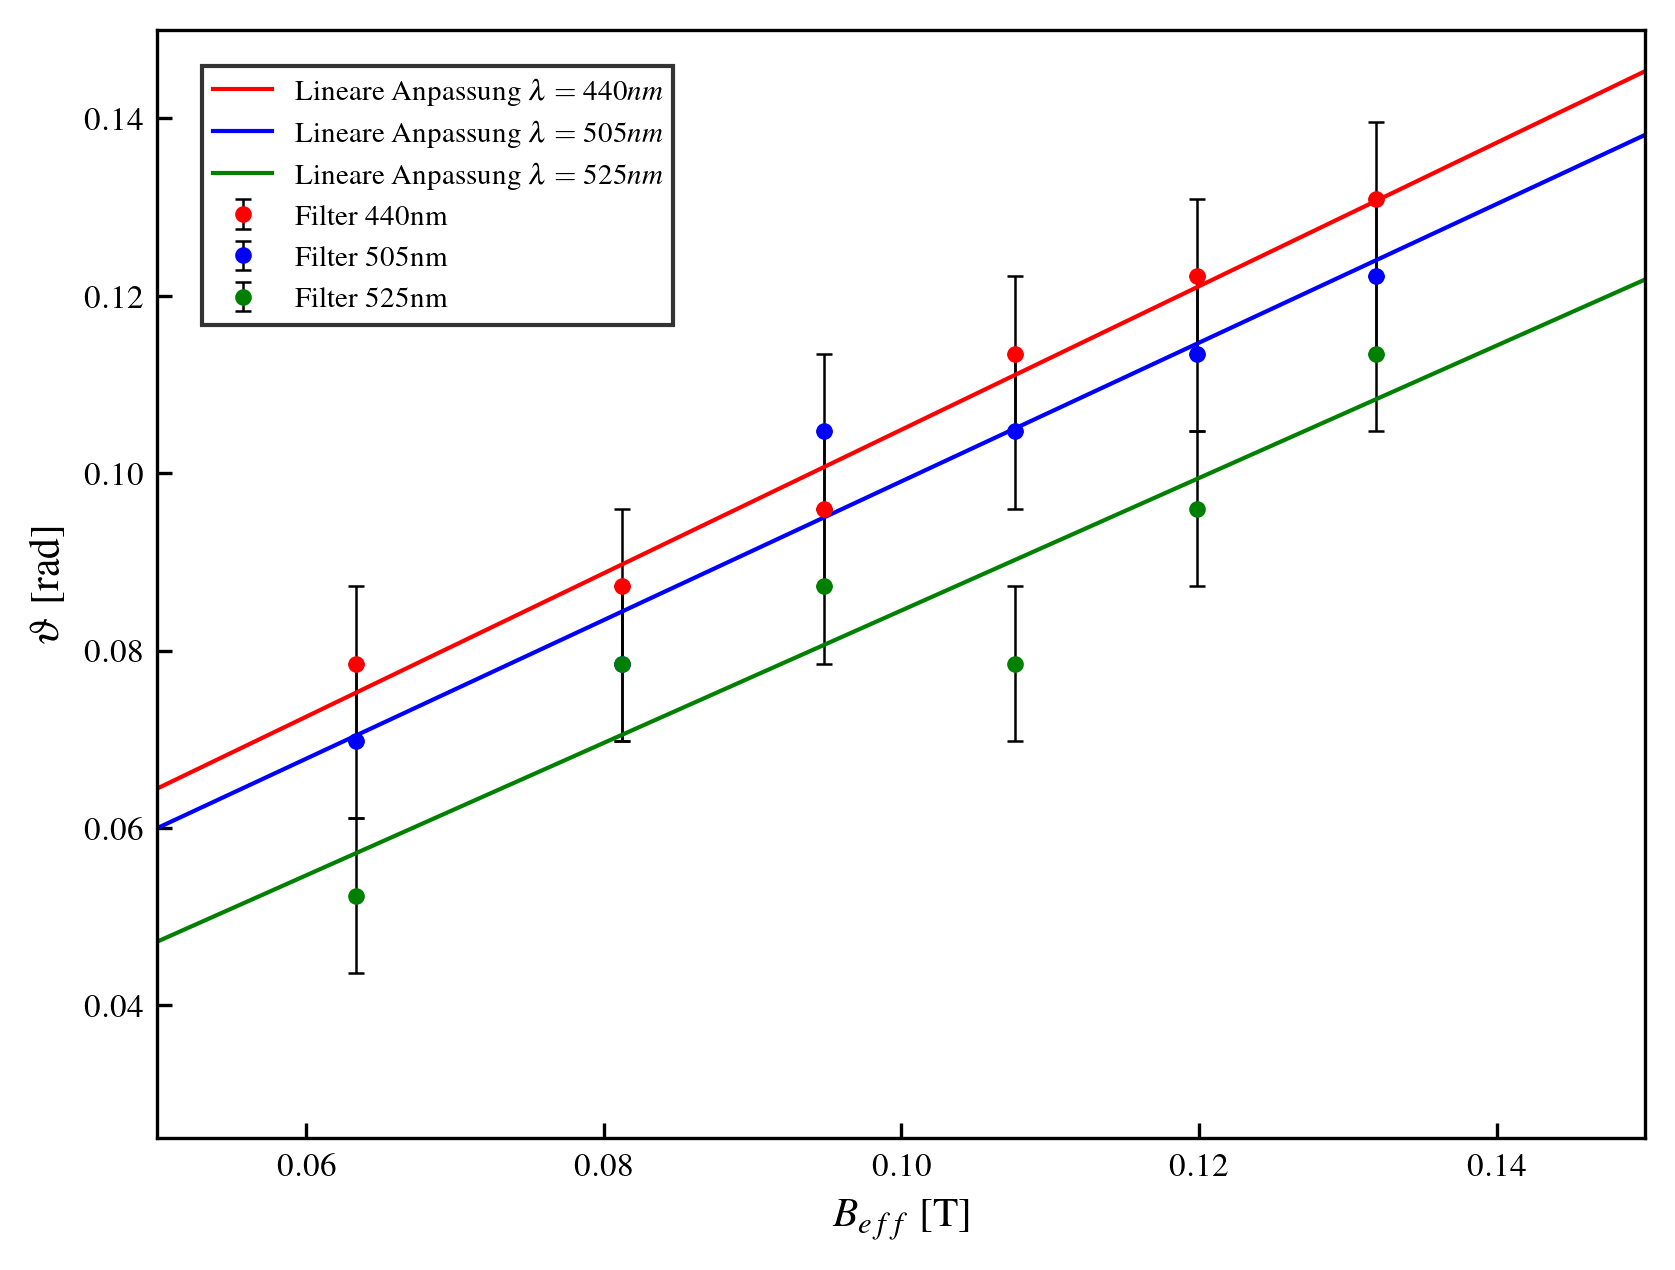

In [2802]:
fig, ax = plt.subplots(dpi=300)

x = np.linspace(0, 1.5, 1000)

#plot data
plt.errorbar(B_eff_all, l_440, yerr=d_440, capsize=2, ecolor='black', elinewidth=0.6, capthick=0.6, markersize=8, fmt=".", markeredgecolor='none', c="red", zorder=2, label='Filter 440nm')
plt.errorbar(B_eff_all, l_505, yerr=d_505, capsize=2, ecolor='black', elinewidth=0.6, capthick=0.6, markersize=8, fmt=".", markeredgecolor='none', c="blue", zorder=2, label='Filter 505nm')
plt.errorbar(B_eff_all, l_525, yerr=d_525, capsize=2, ecolor='black', elinewidth=0.6, capthick=0.6, markersize=8, fmt=".", markeredgecolor='none', c="green", zorder=2, label='Filter 525nm')
# plt.errorbar(B_eff_all, l_580, yerr=d_580, capsize=2, ecolor='black', elinewidth=0.6, capthick=0.6, markersize=8, fmt=".", markeredgecolor='none', c="orange", zorder=2, label='580nm')

#plot fits
plt.plot(x, f_lin(x, popt440[0], popt440[1]), color='red', linewidth=1, label='Lineare Anpassung $\lambda=440nm$', zorder=2)
plt.plot(x, f_lin(x, popt505[0], popt505[1]), color='blue', linewidth=1, label='Lineare Anpassung $\lambda=505nm$', zorder=2)
plt.plot(x, f_lin(x, popt525[0], popt525[1]), color='green', linewidth=1, label='Lineare Anpassung $\lambda=525nm$', zorder=2)
# plt.plot(x, f_lin(x, popt580[0], popt580[1]), color='orange', linewidth=1, label='Fit 580nm', zorder=2)

ax.set_ylim(0.025, 0.15)
ax.set_xlim(0.05, 0.15)
ax.set_ylabel('$\\vartheta$ [rad]')
ax.set_xlabel('$B_{eff}$ [T]')

plt.tick_params(direction='in', labelsize=8)

plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98), fancybox=False, edgecolor='black', fontsize=7)

# fig.savefig("/Users/danielmiksch/Downloads/plot_fits.png")

### Berechnung von V

In [2803]:
l = 0.03045 #m
popt = np.array([popt440[0], popt505[0], popt525[0], popt580[0]])
pcov = np.array([pcov440[0,0], pcov505[0,0], pcov525[0,0], pcov580[0,0]])
print(popt440)
b_best = unumpy.uarray(popt, pcov)

V = np.array([(i / l) for i in b_best])
V = V[:-1]
V_440, V_505, V_525 = V
print(unumpy.nominal_values(V))
print(unumpy.std_devs(V))

[0.8088107    0.0240136516]
[26.5619277519 25.6675231014 24.5154804447]
[0.7843138459 0.7843139882 0.7843140805]


In [2804]:
V_mean = np.mean(unumpy.nominal_values(V))
d_V_mean = np.std(unumpy.nominal_values(V)) / (np.sqrt(len(V)))
V_mean = ufloat(V_mean, d_V_mean)
V_mean

25.58164376601063+/-0.4836247605394373

In [2805]:
v, lamb, e, c, m, n = sp.symbols('v lamb e c m n')

# Definieren Sie die Funktion, die Sie integrieren möchten
eq1 = v * (1/lamb)
eq2 = -e / (2 * m * c)

integrated_eq1 = sp.integrate(eq1, lamb)
integrated_eq2 = sp.integrate(eq2, n)

eq3 = Eq(integrated_eq1, integrated_eq2)

dispersion = solve(eq3, n)
dispersion

[-2*c*m*v*log(lamb)/e]

In [2806]:
c = constants.c
e = constants.elementary_charge
m = constants.electron_mass
lambdas = np.array([440, 505, 525])

In [2807]:
def f_dispersion(V,lamb):
    return -2*V*c*m*np.log(lamb * 1e-9)/e

In [2808]:
x = np.linspace(200, 700, 400)
unumpy.nominal_values(f_dispersion(V, lambdas))

array([1.3253356034, 1.2686521146, 1.2084648558])

In [2809]:
file_path = '/Users/danielmiksch/Downloads/data_glass.csv'
data_glass = pd.read_csv(file_path, sep=',')

In [2810]:
np.set_printoptions(suppress=True, precision=10)
data_glass = data_glass.to_numpy()

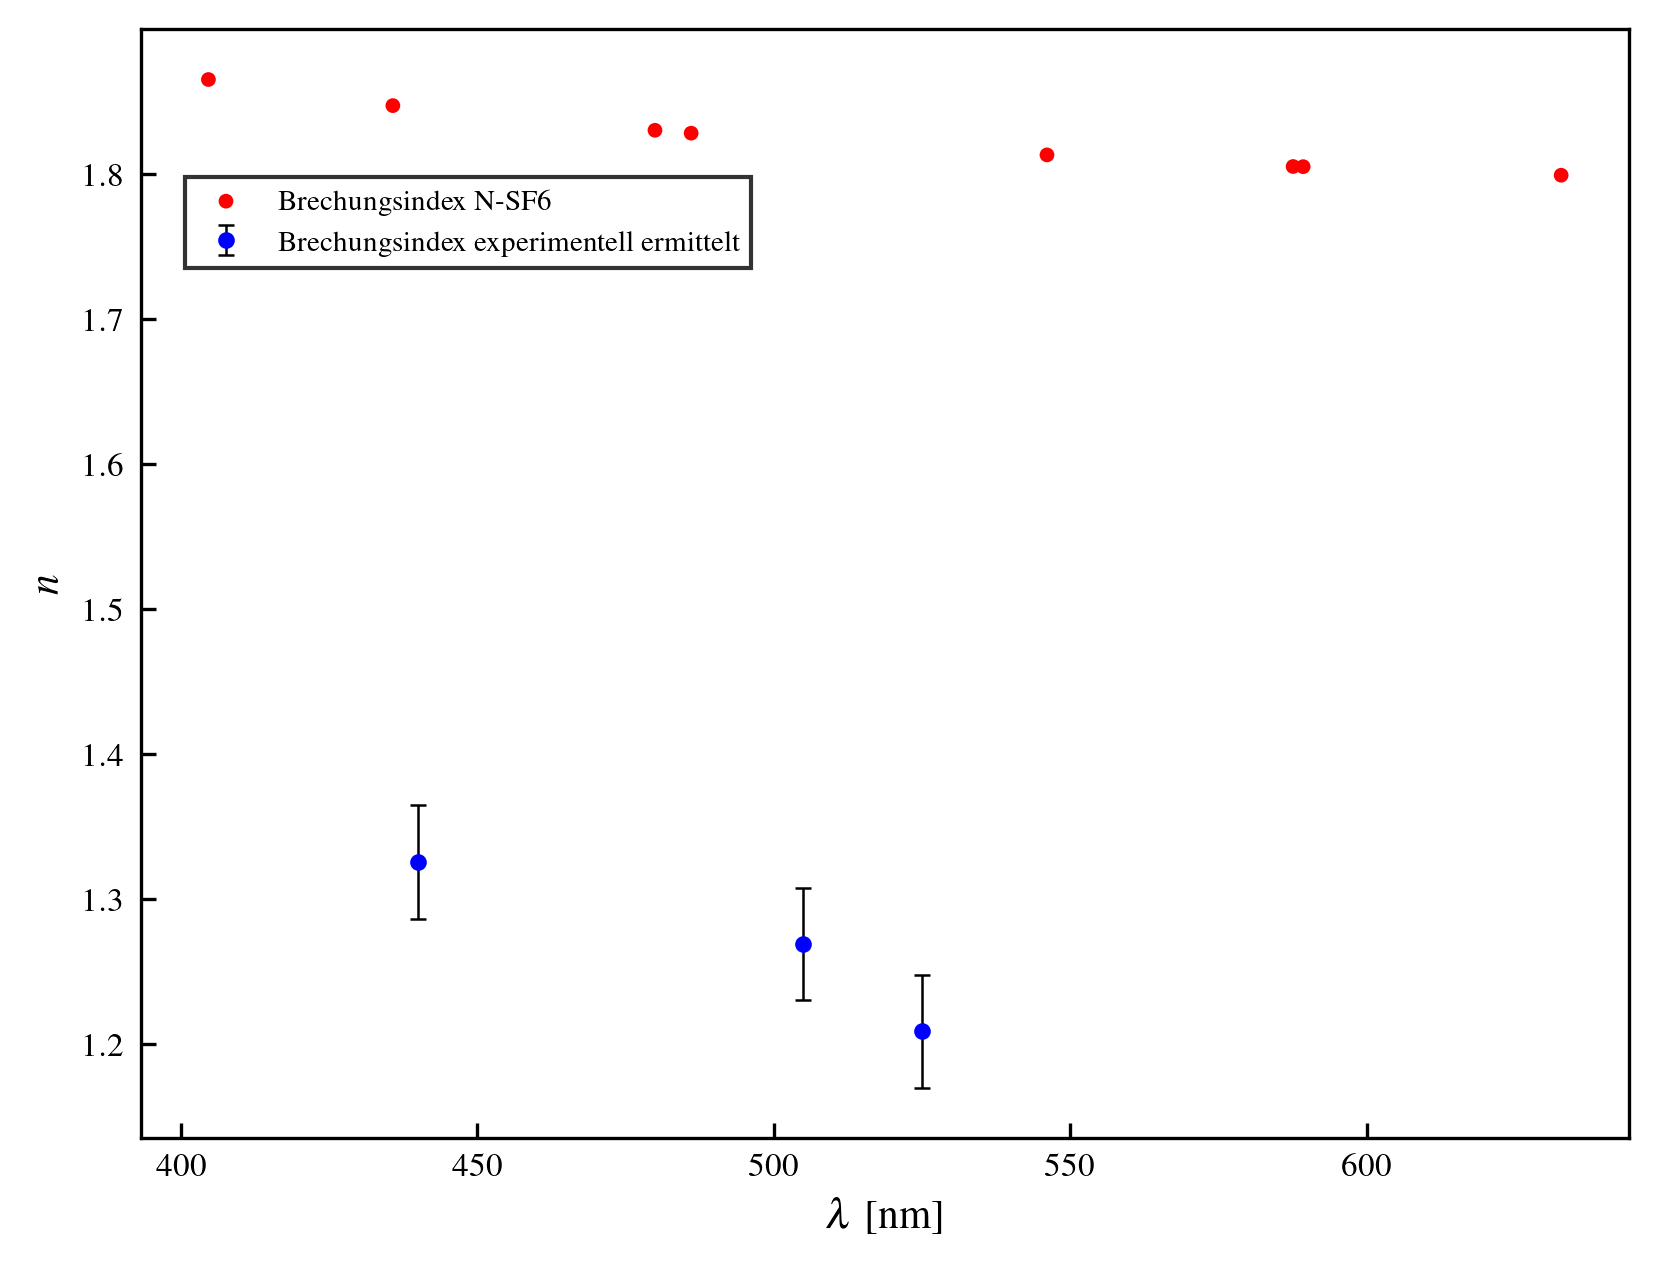

In [2811]:
fig, ax = plt.subplots(dpi=300)

plt.errorbar(lambdas, unumpy.nominal_values(f_dispersion(V, lambdas)), yerr=unumpy.std_devs(f_dispersion(V, lambdas)), capsize=2, ecolor='black', elinewidth=0.6, capthick=0.6, markersize=8, fmt=".", markeredgecolor='none', c="blue", zorder=2, label='Brechungsindex experimentell ermittelt')
plt.scatter(data_glass[:,0], data_glass[:,1], marker='.', s=50, edgecolors='none', color='red', label='Brechungsindex N-SF6', zorder=2)


ax.set_ylabel('$n$')
ax.set_xlabel('$\lambda$ [nm]')

plt.tick_params(direction='in', labelsize=8)

plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.88), fancybox=False, edgecolor='black', fontsize=7)
# plt.plot(x, unumpy.nominal_values(f_dispersion(x)), color='red', linewidth=1, label='Fit 440nm', zorder=2)
# fig.savefig("/Users/danielmiksch/Downloads/plot_nindex.png")

## Neue Berechnungen

In [2812]:
#Slemeier coefficients
B1, B2, B3 = 1.77931763, 0.338149866, 2.08734474
C1, C2, C3 = 0.0133714182 * (1/1000000000000), 0.0617533621 * (1/1000000000000), 174.01759 * (1/1000000000000) #in m^2

In [2813]:
lam = sp.symbols('lam')
f = sp.sqrt((B1*lam**2)/(lam**2-C1) + (B2*lam**2)/(lam**2-C2) + (B3*lam**2)/(lam**2-C3) + 1)
dn_dl = sp.diff(f, lam)
dn_dl

1.44476459674232*(-0.852431127404475*lam**3/(lam**2 - 1.33714182e-14)**2 - 0.162000008680885*lam**3/(lam**2 - 6.17533621e-14)**2 - lam**3/(lam**2 - 1.7401759e-10)**2 + 0.852431127404475*lam/(lam**2 - 1.33714182e-14) + 0.162000008680885*lam/(lam**2 - 6.17533621e-14) + lam/(lam**2 - 1.7401759e-10))/sqrt(0.852431127404475*lam**2/(lam**2 - 1.33714182e-14) + 0.162000008680885*lam**2/(lam**2 - 6.17533621e-14) + lam**2/(lam**2 - 1.7401759e-10) + 0.479077548062329)

In [2814]:
dn_dl_func = sp.lambdify(lam, dn_dl, "numpy")

In [2815]:
def test(lam):
    return np.sqrt((B1*(lam*1e-9)**2)/((lam*1e-9)**2-C1) + (B2*(lam*1e-9)**2)/((lam*1e-9)**2-C2) + (B3*(lam*1e-9)**2)/((lam*1e-9)**2-C3) + 1)

In [2816]:
def calc_V(lam):
    return -(e/(2*m*c))*lam*dn_dl_func(lam)

In [2817]:
calc_V(440*1e-9)

59.87772904041399

In [2818]:
dn_dl_func(546.1*1e-9)

-204467.57316512614

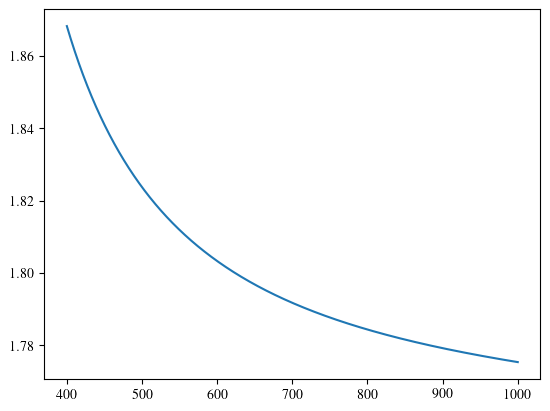

In [2819]:
k = np.linspace(400, 1000, 10000)
plt.plot(k, test(k))

In [2820]:
0.02/(100*1e-9)

200000.0